In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

URL_path = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/clean_dataset.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we will be installing all the modules that are required

In [ ]:
!pip install torchinfo

We will be exploring the Bert model and see if we could find any good performance

In [ ]:
# main libraries
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# PyTorch Libraries
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchinfo import summary  # Model summary tool for PyTorch

# Transformers Library (for BERT and related utilities)
from transformers import BertTokenizer, BertModel, BertConfig

# Evaluation and Metrics
from sklearn import metrics

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# colorama
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)
theme_color

[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [ ]:
dataframe

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,list
0,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
144785,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
144786,You should be ashamed of yourself That is a ho...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
144787,"Spitzer Umm, theres no actual article for pros...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
144788,And it looks like it was actually you who put ...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [ ]:
dataframe = pd.read_csv(URL_path)
dataframe['list'] = dataframe[dataframe.columns[1:]].values.tolist()
dataframe_clean = dataframe[['comment_text', 'list']].copy()
dataframe_clean.head()

,comment_text,list
0,ExplanationWhy the edits made under my usernam...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""MoreI can't make any real suggestions on impr...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


 # Parameters model

In this case, we selected 256 as the maximum token length because values above this threshold represent only about 5% of the data, making them statistically insignificant. Removing these outliers helps streamline training and improve efficiency. For this iteration, we will use training and validation batches of 8, with an initial learning rate set at 1e-05. The first model we will be testing is BERT.

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 200
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class CustomDataset(Dataset):
    """Tokenize the dataset for using it in the model"""
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        values_return = {
                        'ids': torch.tensor(ids, dtype=torch.int64),
                        'mask': torch.tensor(mask, dtype=torch.int64),
                        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int64),
                        'targets': torch.tensor(self.targets[index], dtype=torch.float)
                         }

        return values_return

# split and dataloader

In [ ]:
# split
train_size = 0.8
train_dataset=dataframe_clean.sample(frac=train_size,random_state=42)
test_dataset=dataframe_clean.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(dataframe_clean.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# transforming the dataset
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

# dataloader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

FULL Dataset: (144790, 2)
TRAIN Dataset: (115832, 2)
TEST Dataset: (28958, 2)


# Fine tune the model

In [ ]:
class BertClass(torch.nn.Module):
    def __init__(self):
        super(BertClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        # because we are trying to predict 6 classes
        self.l3 = torch.nn.Linear(768, 6)

    def forward(self, ids, mask, token_type_ids):

        assert isinstance(ids, torch.Tensor), f"Expected tensor, got {type(ids)} for ids"
        assert isinstance(mask, torch.Tensor), f"Expected tensor, got {type(mask)} for mask"
        assert isinstance(token_type_ids, torch.Tensor), f"Expected tensor, got {type(token_type_ids)} for token_type_ids"

        # _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)


        # print(f"Type of outputs: {type(output_1)}")
        output_1 = output_1[1]

        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model_bert = BertClass()
model_bert.to(device)

summary(model_bert)

Layer (type:depth-idx)                                  Param #
BertClass                                               --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           4,614
Total params: 10

# train the model

In [ ]:
# loss function
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

# optimizer
optimizer = torch.optim.Adam(params =  model_bert.parameters(), lr=LEARNING_RATE)


# store loss s can accuracy and calculated
def calculate_accuracy(outputs, targets):
    preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    preds = preds.round()  # Round to get binary predictions
    return (preds == targets).float().mean()  # Calculate accuracy

loss_history = []
accuracy_history = []


# training and epochs
def train(epoch, model, dataset_loader, device, enable_code = False):
    """ Train the model"""
    model.train()

    running_loss = 0.0
    running_accuracy = 0.0
    total_samples = 0

    # run each sample on the model
    for _,data in tqdm(enumerate(dataset_loader, 0)):
        ids =  data['ids'].to(device, dtype = torch.int64)
        mask = data['mask'].to(device, dtype = torch.int8 )
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.int64)
        targets = data['targets'].to(device, dtype=torch.float64)

        outputs = model(ids, mask, token_type_ids)

        # calculate the gradient
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        running_accuracy += calculate_accuracy(outputs, targets).item() * ids.size(0)
        total_samples += ids.size(0)


        if _ % 5000 == 0:
            accuracy = calculate_accuracy(outputs, targets).item()  # Calculate accuracy for current batch
            print(f'Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}')

        # plot the accuracy and the loss
        epoch_loss = running_loss / len(dataset_loader)
        epoch_accuracy = running_accuracy / total_samples
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        if enable_code:
            plt.figure(figsize=(15, 6))

            # Plot loss
            plt.subplot(1, 2, 1)
            plt.plot(loss_history, label='Loss')
            plt.title('Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            # Plot accuracy
            plt.subplot(1, 2, 2)
            plt.plot(accuracy_history, label='Accuracy')
            plt.title('Accuracy Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()

        return model


In [ ]:
for epoch in range(EPOCHS):
    start_time = time.time()

    # Call your training function
    train(epoch, model_bert, training_loader, device)
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds.')
    print("============================================")
    print("============================================")
    print("============================================")

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
0it [00:03, ?it/s]


Epoch: 0, Loss: 0.6319974650396034, Accuracy: 0.6041666865348816
Epoch 1/200 completed in 3.59 seconds.


0it [00:01, ?it/s]


Epoch: 1, Loss: 0.6975011990677255, Accuracy: 0.5208333134651184
Epoch 2/200 completed in 1.06 seconds.


0it [00:00, ?it/s]


Epoch: 2, Loss: 0.6365598793296764, Accuracy: 0.6666666865348816
Epoch 3/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 3, Loss: 0.6180586628227805, Accuracy: 0.6666666865348816
Epoch 4/200 completed in 0.96 seconds.


0it [00:00, ?it/s]


Epoch: 4, Loss: 0.6065633966548679, Accuracy: 0.7291666865348816
Epoch 5/200 completed in 0.94 seconds.


0it [00:00, ?it/s]


Epoch: 5, Loss: 0.6040661716057608, Accuracy: 0.7291666865348816
Epoch 6/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 6, Loss: 0.6211678257095627, Accuracy: 0.6041666865348816
Epoch 7/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 7, Loss: 0.5711204216737921, Accuracy: 0.7916666865348816
Epoch 8/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 8, Loss: 0.5964873742874867, Accuracy: 0.6666666865348816
Epoch 9/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 9, Loss: 0.6038064278739815, Accuracy: 0.6458333134651184
Epoch 10/200 completed in 0.90 seconds.


0it [00:00, ?it/s]


Epoch: 10, Loss: 0.5736432031262666, Accuracy: 0.7708333134651184
Epoch 11/200 completed in 0.99 seconds.


0it [00:00, ?it/s]


Epoch: 11, Loss: 0.5755294161887529, Accuracy: 0.8125
Epoch 12/200 completed in 0.95 seconds.


0it [00:01, ?it/s]


Epoch: 12, Loss: 0.5446845485518376, Accuracy: 0.8125
Epoch 13/200 completed in 1.05 seconds.


0it [00:00, ?it/s]


Epoch: 13, Loss: 0.6067951772905266, Accuracy: 0.6875
Epoch 14/200 completed in 0.98 seconds.


0it [00:00, ?it/s]


Epoch: 14, Loss: 0.5453216176247224, Accuracy: 0.8333333134651184
Epoch 15/200 completed in 0.96 seconds.


0it [00:00, ?it/s]


Epoch: 15, Loss: 0.6034959428167591, Accuracy: 0.6458333134651184
Epoch 16/200 completed in 1.01 seconds.


0it [00:00, ?it/s]


Epoch: 16, Loss: 0.5190825749499103, Accuracy: 0.8541666865348816
Epoch 17/200 completed in 0.93 seconds.


0it [00:00, ?it/s]


Epoch: 17, Loss: 0.5003549829513455, Accuracy: 0.8958333134651184
Epoch 18/200 completed in 0.76 seconds.


0it [00:00, ?it/s]


Epoch: 18, Loss: 0.5377314867509995, Accuracy: 0.7916666865348816
Epoch 19/200 completed in 0.91 seconds.


0it [00:00, ?it/s]


Epoch: 19, Loss: 0.4919804424668352, Accuracy: 0.8333333134651184
Epoch 20/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 20, Loss: 0.5267003538707892, Accuracy: 0.8541666865348816
Epoch 21/200 completed in 0.81 seconds.


0it [00:00, ?it/s]


Epoch: 21, Loss: 0.5396450366824865, Accuracy: 0.8125
Epoch 22/200 completed in 0.92 seconds.


0it [00:00, ?it/s]


Epoch: 22, Loss: 0.4762636083954324, Accuracy: 0.9583333134651184
Epoch 23/200 completed in 1.02 seconds.


0it [00:00, ?it/s]


Epoch: 23, Loss: 0.5221599414168546, Accuracy: 0.875
Epoch 24/200 completed in 0.91 seconds.


0it [00:00, ?it/s]


Epoch: 24, Loss: 0.45803269394673407, Accuracy: 1.0
Epoch 25/200 completed in 0.98 seconds.


0it [00:00, ?it/s]


Epoch: 25, Loss: 0.46751926001161337, Accuracy: 0.9375
Epoch 26/200 completed in 0.84 seconds.


0it [00:00, ?it/s]


Epoch: 26, Loss: 0.4617198791820556, Accuracy: 0.9791666865348816
Epoch 27/200 completed in 0.82 seconds.


0it [00:00, ?it/s]


Epoch: 27, Loss: 0.4347624351115276, Accuracy: 1.0
Epoch 28/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 28, Loss: 0.44927580809841555, Accuracy: 0.9583333134651184
Epoch 29/200 completed in 0.86 seconds.


0it [00:00, ?it/s]


Epoch: 29, Loss: 0.49624372785910964, Accuracy: 0.9375
Epoch 30/200 completed in 0.82 seconds.


0it [00:00, ?it/s]


Epoch: 30, Loss: 0.4053875108559926, Accuracy: 0.9791666865348816
Epoch 31/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 31, Loss: 0.4532653546581666, Accuracy: 0.9166666865348816
Epoch 32/200 completed in 0.86 seconds.


0it [00:01, ?it/s]


Epoch: 32, Loss: 0.4056375757015, Accuracy: 0.9791666865348816
Epoch 33/200 completed in 1.04 seconds.


0it [00:00, ?it/s]


Epoch: 33, Loss: 0.43984066989893716, Accuracy: 0.9375
Epoch 34/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 34, Loss: 0.3965415928202371, Accuracy: 1.0
Epoch 35/200 completed in 0.98 seconds.


0it [00:00, ?it/s]


Epoch: 35, Loss: 0.45754288804406923, Accuracy: 0.875
Epoch 36/200 completed in 0.86 seconds.


0it [00:00, ?it/s]


Epoch: 36, Loss: 0.44868894293904305, Accuracy: 0.9166666865348816
Epoch 37/200 completed in 0.87 seconds.


0it [00:00, ?it/s]


Epoch: 37, Loss: 0.37817208499958116, Accuracy: 1.0
Epoch 38/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 38, Loss: 0.4547763659308354, Accuracy: 0.875
Epoch 39/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 39, Loss: 0.44316870843370754, Accuracy: 0.8958333134651184
Epoch 40/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 40, Loss: 0.33453404329096276, Accuracy: 1.0
Epoch 41/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 41, Loss: 0.36698835839827854, Accuracy: 0.9791666865348816
Epoch 42/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 42, Loss: 0.40234130155295134, Accuracy: 0.9166666865348816
Epoch 43/200 completed in 0.99 seconds.


0it [00:00, ?it/s]


Epoch: 43, Loss: 0.3734650065501531, Accuracy: 0.9791666865348816
Epoch 44/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 44, Loss: 0.32403117635597783, Accuracy: 1.0
Epoch 45/200 completed in 0.86 seconds.


0it [00:00, ?it/s]


Epoch: 45, Loss: 0.3075348635514577, Accuracy: 1.0
Epoch 46/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 46, Loss: 0.35588189276556176, Accuracy: 0.9583333134651184
Epoch 47/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 47, Loss: 0.372113686054945, Accuracy: 0.9375
Epoch 48/200 completed in 0.87 seconds.


0it [00:00, ?it/s]


Epoch: 48, Loss: 0.292812413846453, Accuracy: 1.0
Epoch 49/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 49, Loss: 0.28395585156977177, Accuracy: 1.0
Epoch 50/200 completed in 0.87 seconds.


0it [00:00, ?it/s]


Epoch: 50, Loss: 0.2797917164862156, Accuracy: 1.0
Epoch 51/200 completed in 1.02 seconds.


0it [00:00, ?it/s]


Epoch: 51, Loss: 0.34865184004108113, Accuracy: 0.9375
Epoch 52/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 52, Loss: 0.28165695754190284, Accuracy: 1.0
Epoch 53/200 completed in 0.94 seconds.


0it [00:01, ?it/s]


Epoch: 53, Loss: 0.28207094967365265, Accuracy: 0.9791666865348816
Epoch 54/200 completed in 1.06 seconds.


0it [00:00, ?it/s]


Epoch: 54, Loss: 0.326970557992657, Accuracy: 0.9583333134651184
Epoch 55/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 55, Loss: 0.2854529395699501, Accuracy: 0.9791666865348816
Epoch 56/200 completed in 0.80 seconds.


0it [00:00, ?it/s]


Epoch: 56, Loss: 0.26972441002726555, Accuracy: 1.0
Epoch 57/200 completed in 0.76 seconds.


0it [00:00, ?it/s]


Epoch: 57, Loss: 0.4397587180137634, Accuracy: 0.8125
Epoch 58/200 completed in 0.84 seconds.


0it [00:00, ?it/s]


Epoch: 58, Loss: 0.25309019287427265, Accuracy: 1.0
Epoch 59/200 completed in 0.82 seconds.


0it [00:00, ?it/s]


Epoch: 59, Loss: 0.2618817090988159, Accuracy: 0.9791666865348816
Epoch 60/200 completed in 0.80 seconds.


0it [00:00, ?it/s]


Epoch: 60, Loss: 0.26162957151730853, Accuracy: 0.9791666865348816
Epoch 61/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 61, Loss: 0.2365203003088633, Accuracy: 1.0
Epoch 62/200 completed in 0.76 seconds.


0it [00:00, ?it/s]


Epoch: 62, Loss: 0.24546796083450317, Accuracy: 0.9791666865348816
Epoch 63/200 completed in 0.75 seconds.


0it [00:00, ?it/s]


Epoch: 63, Loss: 0.24894767627120018, Accuracy: 1.0
Epoch 64/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 64, Loss: 0.2881690338253975, Accuracy: 0.9375
Epoch 65/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 65, Loss: 0.21532961229483286, Accuracy: 1.0
Epoch 66/200 completed in 0.85 seconds.


0it [00:00, ?it/s]


Epoch: 66, Loss: 0.29146427537004155, Accuracy: 0.9375
Epoch 67/200 completed in 0.90 seconds.


0it [00:00, ?it/s]


Epoch: 67, Loss: 0.2394079677760601, Accuracy: 1.0
Epoch 68/200 completed in 0.85 seconds.


0it [00:00, ?it/s]


Epoch: 68, Loss: 0.21576125547289848, Accuracy: 1.0
Epoch 69/200 completed in 0.80 seconds.


0it [00:00, ?it/s]


Epoch: 69, Loss: 0.22980507214864096, Accuracy: 0.9791666865348816
Epoch 70/200 completed in 1.00 seconds.


0it [00:00, ?it/s]


Epoch: 70, Loss: 0.3110783286392689, Accuracy: 0.9166666865348816
Epoch 71/200 completed in 0.90 seconds.


0it [00:00, ?it/s]


Epoch: 71, Loss: 0.21304208661119142, Accuracy: 1.0
Epoch 72/200 completed in 0.91 seconds.


0it [00:00, ?it/s]


Epoch: 72, Loss: 0.19436909755071005, Accuracy: 1.0
Epoch 73/200 completed in 0.88 seconds.


0it [00:00, ?it/s]


Epoch: 73, Loss: 0.2050676022966703, Accuracy: 1.0
Epoch 74/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 74, Loss: 0.35838522513707477, Accuracy: 0.8958333134651184
Epoch 75/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 75, Loss: 0.18895385911067328, Accuracy: 1.0
Epoch 76/200 completed in 0.94 seconds.


0it [00:00, ?it/s]


Epoch: 76, Loss: 0.18786498283346495, Accuracy: 1.0
Epoch 77/200 completed in 1.00 seconds.


0it [00:00, ?it/s]


Epoch: 77, Loss: 0.3548283390700817, Accuracy: 0.8958333134651184
Epoch 78/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 78, Loss: 0.22951818878451982, Accuracy: 0.9791666865348816
Epoch 79/200 completed in 0.99 seconds.


0it [00:00, ?it/s]


Epoch: 79, Loss: 0.2228053609530131, Accuracy: 0.9583333134651184
Epoch 80/200 completed in 0.90 seconds.


0it [00:00, ?it/s]


Epoch: 80, Loss: 0.304024505118529, Accuracy: 0.9166666865348816
Epoch 81/200 completed in 0.97 seconds.


0it [00:01, ?it/s]


Epoch: 81, Loss: 0.21189047396183014, Accuracy: 0.9791666865348816
Epoch 82/200 completed in 1.13 seconds.


0it [00:00, ?it/s]


Epoch: 82, Loss: 0.31223350763320923, Accuracy: 0.9166666865348816
Epoch 83/200 completed in 0.90 seconds.


0it [00:00, ?it/s]


Epoch: 83, Loss: 0.3254862328370412, Accuracy: 0.8958333134651184
Epoch 84/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 84, Loss: 0.1692891518274943, Accuracy: 1.0
Epoch 85/200 completed in 0.99 seconds.


0it [00:00, ?it/s]


Epoch: 85, Loss: 0.27190029869476956, Accuracy: 0.9375
Epoch 86/200 completed in 1.02 seconds.


0it [00:00, ?it/s]


Epoch: 86, Loss: 0.16909762596090636, Accuracy: 1.0
Epoch 87/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 87, Loss: 0.30632221698760986, Accuracy: 0.9166666865348816
Epoch 88/200 completed in 0.93 seconds.


0it [00:00, ?it/s]


Epoch: 88, Loss: 0.16567240903774896, Accuracy: 1.0
Epoch 89/200 completed in 0.80 seconds.


0it [00:00, ?it/s]


Epoch: 89, Loss: 0.18183844536542892, Accuracy: 0.9791666865348816
Epoch 90/200 completed in 0.85 seconds.


0it [00:00, ?it/s]


Epoch: 90, Loss: 0.1571507304906845, Accuracy: 1.0
Epoch 91/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 91, Loss: 0.15330903977155685, Accuracy: 1.0
Epoch 92/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 92, Loss: 0.2775067960222562, Accuracy: 0.9166666865348816
Epoch 93/200 completed in 0.92 seconds.


0it [00:00, ?it/s]


Epoch: 93, Loss: 0.248724897702535, Accuracy: 0.9375
Epoch 94/200 completed in 0.84 seconds.


0it [00:00, ?it/s]


Epoch: 94, Loss: 0.1423343668381373, Accuracy: 1.0
Epoch 95/200 completed in 0.83 seconds.


0it [00:00, ?it/s]


Epoch: 95, Loss: 0.15045617272456488, Accuracy: 1.0
Epoch 96/200 completed in 0.76 seconds.


0it [00:00, ?it/s]


Epoch: 96, Loss: 0.2867918113867442, Accuracy: 0.9166666865348816
Epoch 97/200 completed in 0.74 seconds.


0it [00:00, ?it/s]


Epoch: 97, Loss: 0.14199558148781458, Accuracy: 1.0
Epoch 98/200 completed in 0.77 seconds.


0it [00:00, ?it/s]


Epoch: 98, Loss: 0.4544985443353653, Accuracy: 0.8125
Epoch 99/200 completed in 0.82 seconds.


0it [00:00, ?it/s]


Epoch: 99, Loss: 0.3900262862443924, Accuracy: 0.875
Epoch 100/200 completed in 0.86 seconds.


0it [00:00, ?it/s]


Epoch: 100, Loss: 0.2058424378434817, Accuracy: 0.9583333134651184
Epoch 101/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 101, Loss: 0.2533933271964391, Accuracy: 0.9375
Epoch 102/200 completed in 0.95 seconds.


0it [00:01, ?it/s]


Epoch: 102, Loss: 0.13779247055451074, Accuracy: 1.0
Epoch 103/200 completed in 1.03 seconds.


0it [00:00, ?it/s]


Epoch: 103, Loss: 0.1903905582924684, Accuracy: 0.9791666865348816
Epoch 104/200 completed in 0.91 seconds.


0it [00:00, ?it/s]


Epoch: 104, Loss: 0.14368615051110586, Accuracy: 1.0
Epoch 105/200 completed in 0.82 seconds.


0it [00:00, ?it/s]


Epoch: 105, Loss: 0.13651915391286215, Accuracy: 1.0
Epoch 106/200 completed in 0.77 seconds.


0it [00:00, ?it/s]


Epoch: 106, Loss: 0.3123615508278211, Accuracy: 0.8958333134651184
Epoch 107/200 completed in 0.84 seconds.


0it [00:00, ?it/s]


Epoch: 107, Loss: 0.2740168472131093, Accuracy: 0.9166666865348816
Epoch 108/200 completed in 0.93 seconds.


0it [00:00, ?it/s]


Epoch: 108, Loss: 0.16530870646238327, Accuracy: 0.9791666865348816
Epoch 109/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 109, Loss: 0.12184744576613109, Accuracy: 1.0
Epoch 110/200 completed in 0.85 seconds.


0it [00:00, ?it/s]


Epoch: 110, Loss: 0.1235102042555809, Accuracy: 1.0
Epoch 111/200 completed in 0.82 seconds.


0it [00:00, ?it/s]


Epoch: 111, Loss: 0.261942853530248, Accuracy: 0.9166666865348816
Epoch 112/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 112, Loss: 0.24047256261110306, Accuracy: 0.9375
Epoch 113/200 completed in 0.76 seconds.


0it [00:00, ?it/s]


Epoch: 113, Loss: 0.11646619190772374, Accuracy: 1.0
Epoch 114/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 114, Loss: 0.2370813637971878, Accuracy: 0.9375
Epoch 115/200 completed in 0.94 seconds.


0it [00:00, ?it/s]


Epoch: 115, Loss: 0.21855070690313974, Accuracy: 0.9375
Epoch 116/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 116, Loss: 0.22530512263377508, Accuracy: 0.9375
Epoch 117/200 completed in 0.83 seconds.


0it [00:00, ?it/s]


Epoch: 117, Loss: 0.21616737047831217, Accuracy: 0.9375
Epoch 118/200 completed in 0.83 seconds.


0it [00:00, ?it/s]


Epoch: 118, Loss: 0.2344475785891215, Accuracy: 0.9375
Epoch 119/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 119, Loss: 0.14639762789011002, Accuracy: 0.9791666865348816
Epoch 120/200 completed in 0.90 seconds.


0it [00:00, ?it/s]


Epoch: 120, Loss: 0.4045897151033084, Accuracy: 0.8333333134651184
Epoch 121/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 121, Loss: 0.21464053789774576, Accuracy: 0.9375
Epoch 122/200 completed in 0.84 seconds.


0it [00:00, ?it/s]


Epoch: 122, Loss: 0.266128604610761, Accuracy: 0.8958333134651184
Epoch 123/200 completed in 0.85 seconds.


0it [00:00, ?it/s]


Epoch: 123, Loss: 0.13342179358005524, Accuracy: 1.0
Epoch 124/200 completed in 0.80 seconds.


0it [00:00, ?it/s]


Epoch: 124, Loss: 0.12944785878062248, Accuracy: 1.0
Epoch 125/200 completed in 0.76 seconds.


0it [00:00, ?it/s]


Epoch: 125, Loss: 0.13681744039058685, Accuracy: 0.9791666865348816
Epoch 126/200 completed in 0.83 seconds.


0it [00:00, ?it/s]


Epoch: 126, Loss: 0.25347309932112694, Accuracy: 0.9166666865348816
Epoch 127/200 completed in 0.87 seconds.


0it [00:00, ?it/s]


Epoch: 127, Loss: 0.21633013586203256, Accuracy: 0.9375
Epoch 128/200 completed in 0.86 seconds.


0it [00:00, ?it/s]


Epoch: 128, Loss: 0.2486655501027902, Accuracy: 0.8958333134651184
Epoch 129/200 completed in 0.86 seconds.


0it [00:00, ?it/s]


Epoch: 129, Loss: 0.10972933719555537, Accuracy: 1.0
Epoch 130/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 130, Loss: 0.4351772603889306, Accuracy: 0.8125
Epoch 131/200 completed in 0.81 seconds.


0it [00:00, ?it/s]


Epoch: 131, Loss: 0.10221279164155324, Accuracy: 1.0
Epoch 132/200 completed in 0.83 seconds.


0it [00:00, ?it/s]


Epoch: 132, Loss: 0.10499638070662816, Accuracy: 1.0
Epoch 133/200 completed in 0.83 seconds.


0it [00:00, ?it/s]


Epoch: 133, Loss: 0.10561817387739818, Accuracy: 1.0
Epoch 134/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 134, Loss: 0.11217887451251347, Accuracy: 1.0
Epoch 135/200 completed in 0.98 seconds.


0it [00:00, ?it/s]


Epoch: 135, Loss: 0.17230196545521417, Accuracy: 0.9791666865348816
Epoch 136/200 completed in 0.91 seconds.


0it [00:00, ?it/s]


Epoch: 136, Loss: 0.17282623425126076, Accuracy: 0.9583333134651184
Epoch 137/200 completed in 0.92 seconds.


0it [00:00, ?it/s]


Epoch: 137, Loss: 0.23098990321159363, Accuracy: 0.9166666865348816
Epoch 138/200 completed in 0.86 seconds.


0it [00:00, ?it/s]


Epoch: 138, Loss: 0.0980021208524704, Accuracy: 1.0
Epoch 139/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 139, Loss: 0.27933061122894287, Accuracy: 0.8958333134651184
Epoch 140/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 140, Loss: 0.13995262732108435, Accuracy: 0.9583333134651184
Epoch 141/200 completed in 0.81 seconds.


0it [00:00, ?it/s]


Epoch: 141, Loss: 0.08896100521087646, Accuracy: 1.0
Epoch 142/200 completed in 0.75 seconds.


0it [00:00, ?it/s]


Epoch: 142, Loss: 0.1010912259419759, Accuracy: 1.0
Epoch 143/200 completed in 0.77 seconds.


0it [00:00, ?it/s]


Epoch: 143, Loss: 0.09119945019483566, Accuracy: 1.0
Epoch 144/200 completed in 0.81 seconds.


0it [00:00, ?it/s]


Epoch: 144, Loss: 0.09655328343311946, Accuracy: 1.0
Epoch 145/200 completed in 0.77 seconds.


0it [00:00, ?it/s]


Epoch: 145, Loss: 0.100950854520003, Accuracy: 1.0
Epoch 146/200 completed in 0.76 seconds.


0it [00:00, ?it/s]


Epoch: 146, Loss: 0.11108921592434247, Accuracy: 0.9791666865348816
Epoch 147/200 completed in 0.77 seconds.


0it [00:00, ?it/s]


Epoch: 147, Loss: 0.09520355612039566, Accuracy: 1.0
Epoch 148/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 148, Loss: 0.13100813329219818, Accuracy: 0.9791666865348816
Epoch 149/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 149, Loss: 0.09103269129991531, Accuracy: 1.0
Epoch 150/200 completed in 0.88 seconds.


0it [00:00, ?it/s]


Epoch: 150, Loss: 0.2220378965139389, Accuracy: 0.9166666865348816
Epoch 151/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 151, Loss: 0.22216179221868515, Accuracy: 0.9166666865348816
Epoch 152/200 completed in 0.87 seconds.


0it [00:00, ?it/s]


Epoch: 152, Loss: 0.11850138008594513, Accuracy: 0.9791666865348816
Epoch 153/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 153, Loss: 0.0822796771923701, Accuracy: 1.0
Epoch 154/200 completed in 0.86 seconds.


0it [00:00, ?it/s]


Epoch: 154, Loss: 0.11666336158911388, Accuracy: 0.9791666865348816
Epoch 155/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 155, Loss: 0.16700256615877151, Accuracy: 0.9583333134651184
Epoch 156/200 completed in 0.77 seconds.


0it [00:00, ?it/s]


Epoch: 156, Loss: 0.3066625768939654, Accuracy: 0.8333333134651184
Epoch 157/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 157, Loss: 0.09956157455841701, Accuracy: 1.0
Epoch 158/200 completed in 0.81 seconds.


0it [00:00, ?it/s]


Epoch: 158, Loss: 0.12117757648229599, Accuracy: 0.9583333134651184
Epoch 159/200 completed in 0.85 seconds.


0it [00:00, ?it/s]


Epoch: 159, Loss: 0.27281538645426434, Accuracy: 0.8958333134651184
Epoch 160/200 completed in 0.76 seconds.


0it [00:00, ?it/s]


Epoch: 160, Loss: 0.08554820468028386, Accuracy: 1.0
Epoch 161/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 161, Loss: 0.07659750680128734, Accuracy: 1.0
Epoch 162/200 completed in 0.77 seconds.


0it [00:00, ?it/s]


Epoch: 162, Loss: 0.10906231651703517, Accuracy: 0.9791666865348816
Epoch 163/200 completed in 0.85 seconds.


0it [00:00, ?it/s]


Epoch: 163, Loss: 0.0806003933151563, Accuracy: 1.0
Epoch 164/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 164, Loss: 0.10025237997372945, Accuracy: 1.0
Epoch 165/200 completed in 0.93 seconds.


0it [00:00, ?it/s]


Epoch: 165, Loss: 0.08036323388417561, Accuracy: 1.0
Epoch 166/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 166, Loss: 0.09442727267742157, Accuracy: 1.0
Epoch 167/200 completed in 0.83 seconds.


0it [00:00, ?it/s]


Epoch: 167, Loss: 0.11255861446261406, Accuracy: 0.9791666865348816
Epoch 168/200 completed in 0.82 seconds.


0it [00:00, ?it/s]


Epoch: 168, Loss: 0.1722943310936292, Accuracy: 0.9583333134651184
Epoch 169/200 completed in 0.92 seconds.


0it [00:00, ?it/s]


Epoch: 169, Loss: 0.13121005644400915, Accuracy: 0.9791666865348816
Epoch 170/200 completed in 0.98 seconds.


0it [00:00, ?it/s]


Epoch: 170, Loss: 0.2519438515106837, Accuracy: 0.9166666865348816
Epoch 171/200 completed in 0.90 seconds.


0it [00:00, ?it/s]


Epoch: 171, Loss: 0.24958364913860956, Accuracy: 0.9166666865348816
Epoch 172/200 completed in 0.97 seconds.


0it [00:00, ?it/s]


Epoch: 172, Loss: 0.23986572787786523, Accuracy: 0.8958333134651184
Epoch 173/200 completed in 0.98 seconds.


0it [00:01, ?it/s]


Epoch: 173, Loss: 0.0795668934782346, Accuracy: 1.0
Epoch 174/200 completed in 1.08 seconds.


0it [00:00, ?it/s]


Epoch: 174, Loss: 0.08302534868319829, Accuracy: 1.0
Epoch 175/200 completed in 0.95 seconds.


0it [00:00, ?it/s]


Epoch: 175, Loss: 0.3264939586321513, Accuracy: 0.8333333134651184
Epoch 176/200 completed in 0.90 seconds.


0it [00:00, ?it/s]


Epoch: 176, Loss: 0.22487662235895792, Accuracy: 0.9166666865348816
Epoch 177/200 completed in 0.89 seconds.


0it [00:00, ?it/s]


Epoch: 177, Loss: 0.09201401223738988, Accuracy: 1.0
Epoch 178/200 completed in 0.92 seconds.


0it [00:00, ?it/s]


Epoch: 178, Loss: 0.0830003668864568, Accuracy: 1.0
Epoch 179/200 completed in 0.76 seconds.


0it [00:00, ?it/s]


Epoch: 179, Loss: 0.13305548454324403, Accuracy: 0.9791666865348816
Epoch 180/200 completed in 0.74 seconds.


0it [00:00, ?it/s]


Epoch: 180, Loss: 0.22621983662247658, Accuracy: 0.9166666865348816
Epoch 181/200 completed in 0.77 seconds.


0it [00:00, ?it/s]


Epoch: 181, Loss: 0.10368678718805313, Accuracy: 0.9791666865348816
Epoch 182/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 182, Loss: 0.07706435273090999, Accuracy: 1.0
Epoch 183/200 completed in 0.91 seconds.


0it [00:00, ?it/s]


Epoch: 183, Loss: 0.11214186747868855, Accuracy: 0.9791666865348816
Epoch 184/200 completed in 0.97 seconds.


0it [00:01, ?it/s]


Epoch: 184, Loss: 0.13694816579421362, Accuracy: 0.9583333134651184
Epoch 185/200 completed in 1.06 seconds.


0it [00:00, ?it/s]


Epoch: 185, Loss: 0.19241461902856827, Accuracy: 0.9375
Epoch 186/200 completed in 0.97 seconds.


0it [00:00, ?it/s]


Epoch: 186, Loss: 0.07238323986530304, Accuracy: 1.0
Epoch 187/200 completed in 0.97 seconds.


0it [00:00, ?it/s]


Epoch: 187, Loss: 0.11457351843516032, Accuracy: 0.9791666865348816
Epoch 188/200 completed in 1.02 seconds.


0it [00:00, ?it/s]


Epoch: 188, Loss: 0.10188524921735127, Accuracy: 1.0
Epoch 189/200 completed in 0.81 seconds.


0it [00:00, ?it/s]


Epoch: 189, Loss: 0.06731689721345901, Accuracy: 1.0
Epoch 190/200 completed in 0.82 seconds.


0it [00:00, ?it/s]


Epoch: 190, Loss: 0.06335930029551189, Accuracy: 1.0
Epoch 191/200 completed in 0.74 seconds.


0it [00:00, ?it/s]


Epoch: 191, Loss: 0.13627449174722037, Accuracy: 0.9583333134651184
Epoch 192/200 completed in 0.81 seconds.


0it [00:00, ?it/s]


Epoch: 192, Loss: 0.09946710119644801, Accuracy: 0.9791666865348816
Epoch 193/200 completed in 0.78 seconds.


0it [00:00, ?it/s]


Epoch: 193, Loss: 0.1900598406791687, Accuracy: 0.9166666865348816
Epoch 194/200 completed in 0.83 seconds.


0it [00:00, ?it/s]


Epoch: 194, Loss: 0.07130337754885356, Accuracy: 1.0
Epoch 195/200 completed in 0.79 seconds.


0it [00:00, ?it/s]


Epoch: 195, Loss: 0.15872658292452493, Accuracy: 0.9583333134651184
Epoch 196/200 completed in 0.74 seconds.


0it [00:00, ?it/s]


Epoch: 196, Loss: 0.0738489106297493, Accuracy: 1.0
Epoch 197/200 completed in 0.91 seconds.


0it [00:00, ?it/s]


Epoch: 197, Loss: 0.06362423300743103, Accuracy: 1.0
Epoch 198/200 completed in 0.83 seconds.


0it [00:00, ?it/s]


Epoch: 198, Loss: 0.0710069810350736, Accuracy: 1.0
Epoch 199/200 completed in 0.86 seconds.


0it [00:00, ?it/s]

Epoch: 199, Loss: 0.07031010339657466, Accuracy: 1.0
Epoch 200/200 completed in 0.79 seconds.


0it [00:00, ?it/s]

Epoch: 0, Loss: 0.08327458426356316, Accuracy: 0.9791666865348816


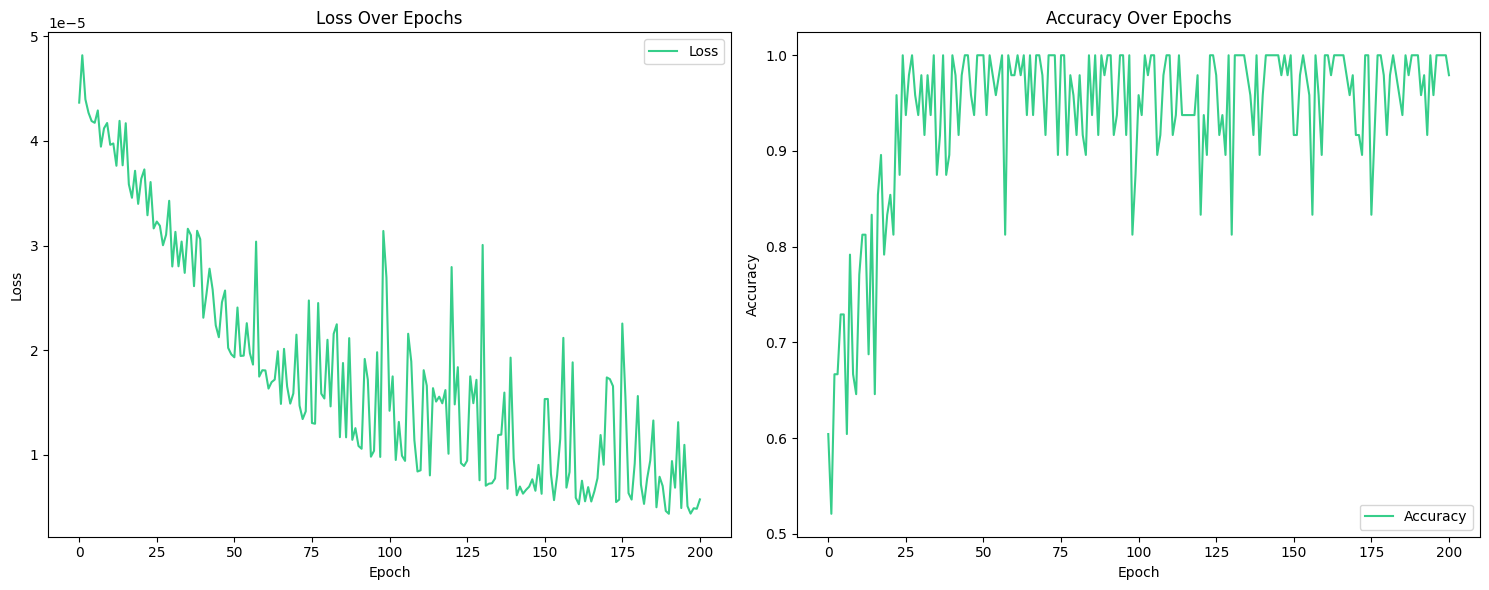

0it [00:01, ?it/s]

Epoch 1/1 completed in 1.43 seconds.


In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    start_time = time.time()

    # Call your training function
    train(epoch, model_bert, training_loader, device, enable_code= True)
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds.')
    print("============================================")
    print("============================================")
    print("============================================")

After seeing the model traing for 200 epochs we could see that the accuracy of its for 80% so we will need to validate it to see how it handle its.

# Validation set

In [ ]:
def validation(epoch,model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for data in data_loader:
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            # Get model outputs
            outputs = model(ids, mask, token_type_ids)

            # Calculate loss
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

            # Assuming outputs are logits for binary classification, apply a sigmoid activation
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (predictions == targets).sum().item()  # Count correct predictions
            total_samples += targets.size(0)  # Count total samples

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch: {epoch}, Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    return avg_loss, accuracy


In [ ]:
def validation(epoch, model, dataloader, device):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(dataloader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    start_time = time.time()

    # Call your training function
    # train(epoch, model_bert, training_loader, device)

    # validation
    # Initialize lists to store metrics for each epoch
    epoch_accuracies = []
    epoch_f1_micro = []
    epoch_f1_macro = []

    # Call the validation function
    outputs, targets = validation(epoch, model_bert, testing_loader, device)
    # output = validation(epoch, model_bert, testing_loader, device)
    print(outputs)

    end_time = time.time()
    epoch_duration = start_time - end_time

    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

    # Store metrics
    epoch_accuracies.append(accuracy)
    epoch_f1_micro.append(f1_score_micro)
    epoch_f1_macro.append(f1_score_macro)

    # Plot Accuracy and F1 Scores over Epochs with Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=list(range(1, EPOCHS + 1)),
        y=epoch_accuracies,
        mode='lines+markers',
        name='Accuracy'
    ))

    fig.add_trace(go.Scatter(
        x=list(range(1, EPOCHS + 1)),
        y=epoch_f1_micro,
        mode='lines+markers',
        name='F1 Score (Micro)'
    ))

    fig.add_trace(go.Scatter(
        x=list(range(1, EPOCHS + 1)),
        y=epoch_f1_macro,
        mode='lines+markers',
        name='F1 Score (Macro)'
    ))

    fig.update_layout(
        title="Accuracy and F1 Scores over Epochs",
        xaxis_title="Epoch",
        yaxis_title="Score",
        legend_title="Metrics",
    )

    fig.show()

    end_time = time.time()
    epoch_duration = end_time - start_time
    print("============================================")
    print(f'Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds.')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")


3620it [13:22,  4.51it/s]


[[0.06805229932069778, 0.04702910780906677, 0.06393366307020187, 0.03836538642644882, 0.05254194512963295, 0.0380668081343174], [0.05809706449508667, 0.05032939836382866, 0.058712854981422424, 0.03963840380311012, 0.05223538726568222, 0.04301605746150017], [0.3127554655075073, 0.05919199436903, 0.13320106267929077, 0.05959697440266609, 0.1013803482055664, 0.09522620588541031], [0.05501537397503853, 0.05373404175043106, 0.06040681153535843, 0.040379371494054794, 0.052941903471946716, 0.04167028144001961], [0.14066682755947113, 0.04086548462510109, 0.08229122310876846, 0.03919348120689392, 0.07256601005792618, 0.048131220042705536], [0.053635623306035995, 0.06201748549938202, 0.06678098440170288, 0.04408029094338417, 0.0617956779897213, 0.04748629406094551], [0.06044783443212509, 0.0505521297454834, 0.06284160166978836, 0.03952890262007713, 0.0590837299823761, 0.04006370157003403], [0.08270445466041565, 0.04136858507990837, 0.06611630320549011, 0.036722492426633835, 0.054265931248664856,

Epoch 1/1 completed in 803.68 seconds.
Accuracy Score = 0.898059258236066
F1 Score (Micro) = 0.27977513400444504
F1 Score (Macro) = 0.10806988437571612


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.



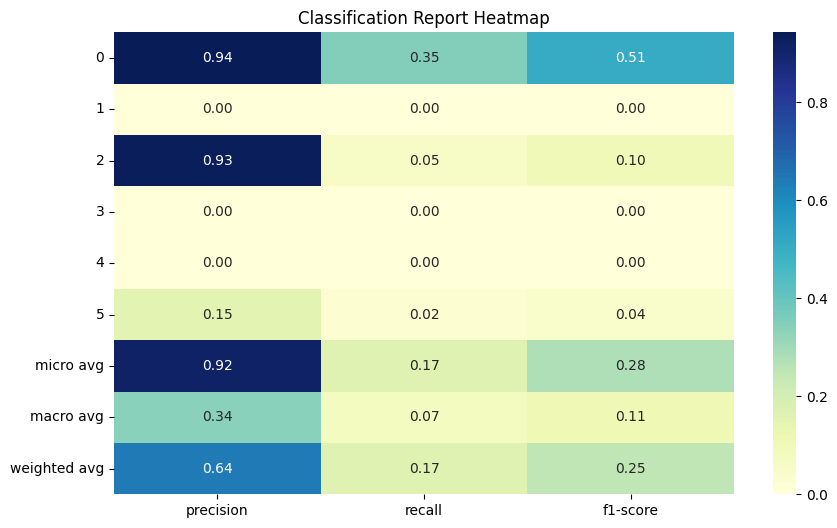

In [ ]:
report = metrics.classification_report(targets, outputs, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", cbar=True, fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

# Export the model
We will be exporting the model

In [ ]:
URL_path = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model"
torch.save(model_bert, f'{URL_path}/001_model_bert.pth')

# Load the model

In [ ]:
model_bert_loaded = torch.load(f'{URL_path}/001_model_bert.pth')
model_bert_loaded

<ipython-input-32-ac26e69c5ff7>:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

# Summary

The model appears to be performing well overall, but we need to experiment with the sample size. The current results are not ideal for target variables with fewer samples, likely due to data imbalance. We'll address this issue to improve performance on these underrepresented classes before proceeding further.